# RL homework 3

-------------------------------


**Name:** John Goodacre

**SN:** 13064947

-----------------------------------


**Start date:** *7th March 2018*

**Due date:** *21st March 2018, 11:55 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw3.ipynb** before the deadline above.

Also send a **sharable link** to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

Please compile all results and all answers to the understanding questions into a PDF. Name convention: **studentnumber_RL_hw3.pdf**. Do not include any of the code (we will use the notebook for that). 

**Page limit: 10 pg **


## Context

In this assignment, we will investigate the properties of 3 distinct reinforcement learning algorithms:

* Online Q-learning
* Experience Replay
* Dyna-Q

We will consider two different dimensions:
* Tabular vs Function Approximation
* Stationary vs Non-Stationary environments

## Background reading

* Sutton and Barto (2018), Chapters 8

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms **[50 pts]**.

You will then run these algorithms on a few problems, to understand their properties.

Finally you will answer a few question about the performance of these algorithms in the various problems **[50pts]**.

# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')
%matplotlib inline

# Grid worlds

**Tabular Grid-World**

Simple tabular grid world.

You can visualize the grid worlds we will train our agents on, by running the cells below.
`S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.

We will use three distinct GridWorlds:
* `Grid` tabular grid world withh a goal in the top right of the grid
* `AltGrid` tabular grid world withh a goal in the bottom left of the grid
* `FeatureGrid` a grid world with a non tabular representation of states, the features are such to allow some degree of state aliasing

In [2]:
#@title Grid
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()

In [3]:
#@title AltGrid
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

In [4]:
#@title FeatureGrid
class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

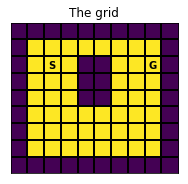

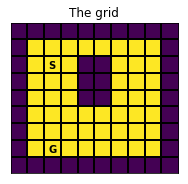

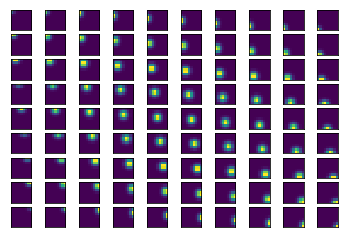

In [5]:
# Instantiate the two tabular environments
grid = Grid()
alt_grid = AltGrid()

# Plot tabular environments
grid.plot_grid()
alt_grid.plot_grid()

# Instantiate the non tabular version of the environment.
feat_grid = FeatureGrid()

# Plot the features of each state
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)), interpolation='nearest')
  ax.set_xticks([])
  ax.set_yticks([])

# Helper functions

In [6]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
def random_policy(q):
  return np.random.randint(4)

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.hold('on')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

# Part 1: Implement Agents

Each agent, should implement a step function:

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `q_values()`:

Tabular agents implement a function `q_values()` returning a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

### `q_values(state)`:

Agents with Linear function approximation implement a method `q_values(state)` returning an array of Q values of shape: (`number_of_actions`)


### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  As in the previous assignment you can use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Q-learning and it's variants needs to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._action = 0
  (...)
```



# Part 1: Implement Agents

We are going to implement 5 agent:
- Online Tabular Q-learning
- Tabular Experience Replay
- Tabular Dyna-Q (with a Tabular model)
- Experience Replay with linear function approximation
- Dyna-Q with linear function approximation (with a linear model)



## 1.1 Tabular Model
**[5 pts]** Implement a trainable tabular Model of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

Given that the environment is deterministic and tabular the model will basically reduce to a simple lookup table.

In [7]:
#Note my home environment is Python3 so I did slight trivial alterations to enable this
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self.number_of_states = number_of_states
    self.number_of_actions = number_of_actions
    
    #this is all deterministic - so learning simply means populating tables - thus for _next_state 
    #we can somewhat unusually use a single number rather than a probability dist over states etc.
    #However, there are different ways of doing this - taking an average will be slower to react to 
    #a changing environment than just taking the last deterministic values for example.
    
    self._next_state = np.zeros((self.number_of_states, self.number_of_actions))
    self._reward = np.zeros((self.number_of_states, self.number_of_actions))
    self._discount = np.zeros((self.number_of_states, self.number_of_actions))

  def next_state(self, s, a):
    #Self explanatory - returning next state, given a state and action
    return self._next_state[s,a]
  
  def reward(self, s, a):
    #Returning reward, given a state and action
    return self._reward[s,a]

  def discount(self, s, a):
    #Returning discount, given a state and action
    return self._discount[s,a]
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    #Note the update here is the agent wondering around and populating a lookup table
    #an alternative would be actually learning or using an average...this would be slower 
    #to react to the non-stationary environment at the end
    self._next_state[state,action] = next_state
    self._reward[state,action] = reward
    self._discount[state,action] = discount

## 1.2 Linear Model

**[5 pts]** Implement a trainable linear model of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward, discount and next state will all be a linear function of the state.
* $\text{s'} = T_a s$
* $\text{r'} = R_a s$
* $\text{g'} = G_a s$

Where $T_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $R_a$ and $G_a$are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by gradient descent. Write down the update to the parameters of the models and implement the update in the model below.



In [8]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    #No states - we represent state by its exposure to features
    #Thus we now model a vector for reward and discount to enable a dot product with
    #the feature vector
    self.number_of_features = number_of_features
    self.number_of_actions = number_of_actions
    #We are doing q values so I will have a state transtion matrix for each action
    self._trans = np.zeros((number_of_features,number_of_features,number_of_actions))
    self._r = np.zeros((number_of_features,number_of_actions))
    self._g = np.zeros((number_of_features,number_of_actions))

  def next_state(self, s, a):
    #return the state transition matrix for the state and action
    return np.dot(self._trans[:,:,a],s)
  
  def reward(self, s, a):
    #return the expected reward for the state and action
    return np.dot(self._r[:,a].T,s)

  def discount(self, s, a):
    #return the learned discount for the state and action
    return np.dot(self._g[:,a].T,s)

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    #Update does stochastic gradient descent to learn the transition matrix, reward vector
    #and discount vector given experiences, feels a bit odd learning a discount vector, 
    #I would expect logically this is not really a part of the model environment, but anyway it works
    #Being extra careful with numpy and reshaping things...for the correct format...
    s = state.reshape(-1,1)
    a = action
    r = reward
    g = discount
    next_s = next_state.reshape(-1,1)

    #The learning bit...
    self._trans[:,:,a] = self._trans[:,:,a] + step_size*(next_s - np.dot(self._trans[:,:,a],s))*s.T
    self._r[:,a] = self._r[:,a] + (step_size*(r - np.dot(self._r[:,a].T,s))*s).reshape(-1)
    self._g[:,a] = self._g[:,a] + (step_size*(g - np.dot(self._g[:,a].T,s))*s).reshape(-1)


## 1.3 Experience Replay

**[10 pts]** Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning 
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A, R, \gamma, S' \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [9]:
class ExperienceQ(object):
  def __init__(
    self, number_of_states, number_of_actions, initial_state, 
    behaviour_policy, num_offline_updates=0, step_size=0.1):

    #Tabular form here - initialise q values, initial state and action
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    
    #Experience replay will story a buffer of experiences and replay to update the q values
    #as well as the online learning bit
    self._num_offline_updates = num_offline_updates
    self._replay = []
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    #Online update of q values - note random policy but max evaluation for q values estimation
    self._q[s,a] = self._q[s,a] + self._step_size*(r + g*np.max(self._q[next_s,:]) - self._q[s,a])
    
    #add experience to replay buffer
    self._replay.append((s,a,r,g,next_s))

    #Repay memories from the buffer to update our q values more times
    for i in range(self._num_offline_updates):
        
      #uniform sampling
      ind = np.random.randint(0,len(self._replay))
      s,a,r,g,next_s = self._replay[ind]
      
      #relay the sample and update q values
      self._q[s,a] = self._q[s,a] + self._step_size*(r + g*np.max(self._q[next_s,:]) - self._q[s,a])
    
    #take a random next action and update the state, action 
    next_action = np.random.randint(self._number_of_actions)
    self._state = next_state
    self._action = next_action
    return next_action


## 1.4 Dyna-Q
**[10 pts]** Implement an agent that uses **Dyna-Q** to learn action values.  
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A)$

6. $\text{Model}.\text{update}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  2. $R, \gamma, S' \gets \text{Model}.\text{transition}(S, A)$
  
  3. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [10]:
class DynaQ(object):
  def __init__(
    self, number_of_states, number_of_actions, initial_state, 
    behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self._q = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    
    self._num_offline_updates = num_offline_updates
    self._replay = []
    
    #Very similar to experience replay but now we are going to learn a model
    self._model = TabularModel(number_of_states, number_of_actions)
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    #Update q value in an online fashion
    self._q[s,a] = self._q[s,a] + self._step_size*(r + g*np.max(self._q[next_s,:]) - self._q[s,a])
    #add experience to buffer
    self._replay.append((s,a,r,g,next_s))
    
    #Learning part of the model, learning from real online experience
    self._model.update(s, a, r, g, next_s)

    #Replay experiences
    for i in range(self._num_offline_updates):
      #Uniform random sampling of previous state actions
      #note unlike experience replay I do not want the r,g,next_s from memory
      ind = np.random.randint(0,len(self._replay))
      s,a,_,_,_ = self._replay[ind]
        
      #Use the learned model in a generative fashion to generate next r,g,next_s
      r,g, next_s = self._model.transition(s,a)
      next_s = int(next_s)

      #Update q values from model generated experiences
      self._q[s,a] = self._q[s,a] + self._step_size*(r + g*np.max(self._q[next_s,:]) - self._q[s,a])
    
    #take random action and update state, action
    next_action = np.random.randint(self._number_of_actions)
    self._state = next_state
    self._action = next_action
    
    return next_action

## 1.5 Experience Replay with Linear Function Approximation

**[10 pts]** Implement an agent that uses **Experience Replay** to learn action values as a linear function approximation over a given set of features.

**Training**: To make sure of the experience in an online fashion, we will learn this linear model via gradient descent. Write down the update to the parameters of the value function and implement the update in the agent below.

In [11]:
class FeatureExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    
    #Experience replay with linear function approximation, states are now
    #vectors of features
    self._number_of_features = number_of_features
    self._replay = []
    #q values are parameterised weights now - thus dimension features x actions
    self._Qtheta = np.zeros((self._number_of_features,self._number_of_actions))

  def q(self, state):
    #extra careful about dimensions - return predicted q value for the state
    #using dot product with learned q values - note multiple actions so we return
    #a vector of q values for each action
    state = state.reshape(-1,1)
    return np.dot(state.T,self._Qtheta)

  def step(self, reward, discount, next_state):
    #Same careful setup with numpy dimensions
    s = self._state.reshape(-1,1)
    a = self._action
    r = reward
    g = discount
    next_s = next_state.reshape(-1,1)
    
    #Calculate the error for Q_theta our parameterised q for that action against max
    delta = r + g*np.max(np.dot(next_s.T,self._Qtheta)) - np.dot(s.T,self._Qtheta[:,a])
    
    #Update Q_theta parameters online from real experience
    self._Qtheta[:,a] = self._Qtheta[:,a] + (self._step_size*delta*s).reshape(-1)
    
    #Add experience to the replay buffer
    self._replay.append((s,a,r,g,next_s))
    #self._model.update(s, a, r, g, next_s, self._step_size)
    
    #Begin updating qtheta parameters from replay experiences
    for i in range(self._num_offline_updates):
      #Uniform random sample of prior experiences
      ind = np.random.randint(0,len(self._replay))
      #Grab actual previous experiences
      s,a,r,g,next_s = self._replay[ind]
       
      #Qtheta update - from prior experiences
      delta = r + g*np.max(np.dot(next_s.T,self._Qtheta)) - np.dot(s.T,self._Qtheta[:,a])
      self._Qtheta[:,a] = self._Qtheta[:,a] + (self._step_size*delta*s).reshape(-1)

    #take a random next action and update state and action
    next_action = np.random.randint(self._number_of_actions)
    self._state = next_state
    self._action = next_action
    return self._action


## 1.6 Dyna-Q with Linear Function Approximation

**[10 pts]** Implement an agent that uses **Dyna-Q** that uses a linear function approximation to represent the value functions and a learnt linear model of the environment (represent and learn both the **transition model**(action conditioned) and the **reward model** as linear transformations of the given set of features).  
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition, use a step_size of 0.01
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A)$

6. $\text{Model}.\text{update}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  2. $R, \gamma, S' \gets \text{Model}.\text{transition}(S, A)$
  
  3. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [13]:
class FeatureDynaQ(DynaQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    
    #Similar to feature experience q but now we will be learning a linear
    #model along the way and using that to generate our imagined experiences
    self._number_of_features = number_of_features
    self._replay = []
    self._Qtheta = np.zeros((self._number_of_features,self._number_of_actions))
    self._model = LinearModel(self._number_of_features, self._number_of_actions)

  def q(self, state):
    state = state.reshape(-1,1)
    return np.dot(state.T,self._Qtheta)

  def step(self, reward, discount, next_state):
    s = self._state.reshape(-1,1)
    a = self._action
    r = reward
    g = discount
    next_s = next_state.reshape(-1,1)
    
    #Update qtheta parameters with real online experiences
    delta = r + g*np.max(np.dot(next_s.T,self._Qtheta)) - np.dot(s.T,self._Qtheta[:,a])
    self._Qtheta[:,a] = self._Qtheta[:,a] + (self._step_size*delta*s).reshape(-1)
    
    #update replay buffer
    self._replay.append((s,a,r,g,next_s))
    #Update linear model with real online experience
    self._model.update(s, a, r, g, next_s, self._step_size)
    
    for i in range(self._num_offline_updates):
      #Uniformly choose a prior experience
      ind = np.random.randint(0,len(self._replay))
      #Because we generate from our model unlike experience replay we wont
      #grab r,g,next_s
      s,a,_,_,_ = self._replay[ind]
       
      #given a state action, generate the rest of the experience from the learned model
      r,g,next_s = self._model.transition(s,a)
      r = float(r)
      g = float(g)
        
      #update qtheta parameters with model generated experiences
      delta = r + g*np.max(np.dot(next_s.T,self._Qtheta)) - np.dot(s.T,self._Qtheta[:,a])
      self._Qtheta[:,a] = self._Qtheta[:,a] + (self._step_size*delta*s).reshape(-1)

    #take a random next action and update state and action
    next_action = np.random.randint(self._number_of_actions)
    self._state = next_state
    self._action = next_action
    return self._action

# Assignment 2: Analyse Results

## 2.1 Tabular Learning

### 2.1.1 Data Efficiency

**Online Q-learning**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

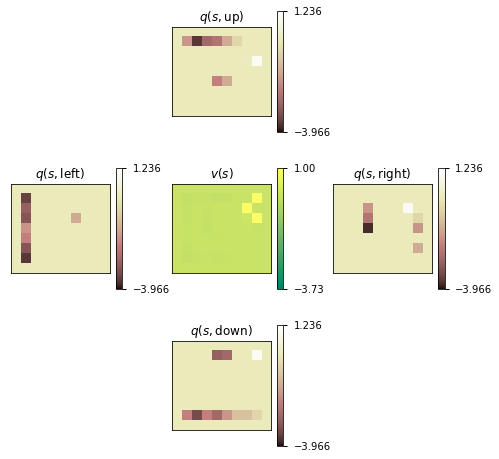

In [15]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

**Experience Replay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

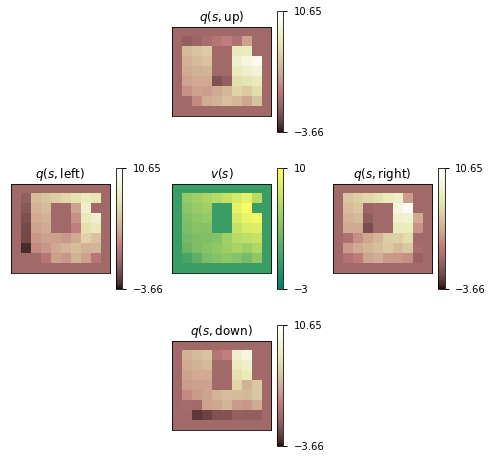

In [16]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

**DynaQ**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

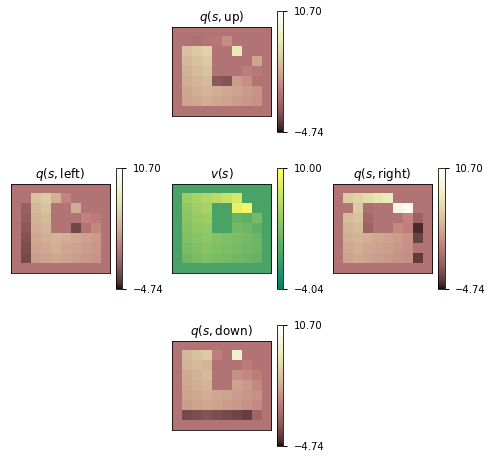

In [17]:
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### 2.1.2 Computational Cost

What if sampling from the environment is cheap and I don't care about data efficiency but only care about the number of updates to the model?

How do Online Q-learning, ExperienceReplay and Dyna-Q compare if I apply the same number of total updates?

**Online Q-learning**

* $\text{number_of_steps}$ = $3e4$ and $\text{num_offline_updates}$ = $0$



/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


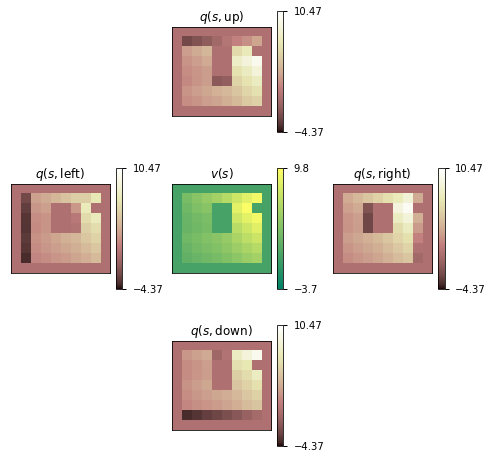

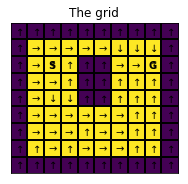

In [18]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(3e4))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

**ExperienceReplay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


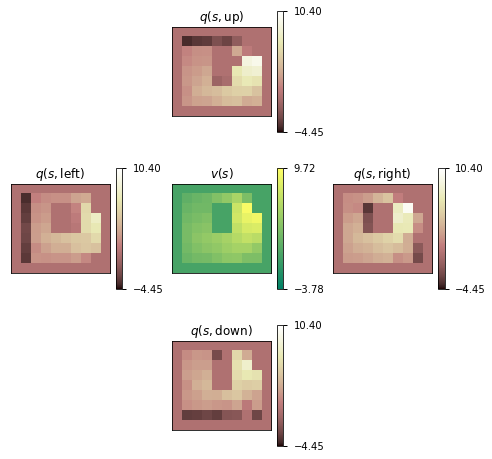

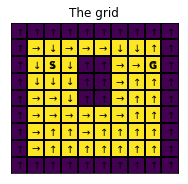

In [28]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

**DynaQ**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


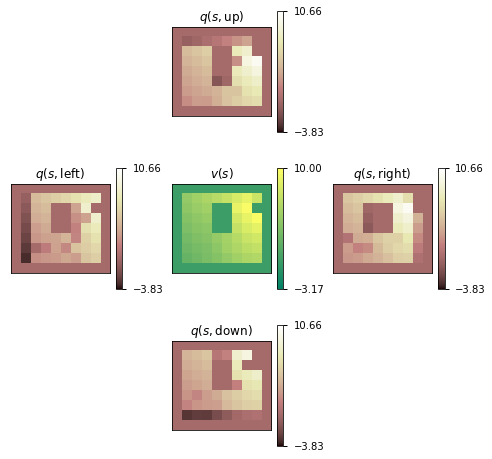

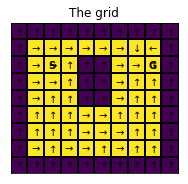

In [29]:
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

## 2.3 Linear function approximation

We will now consider the $\text{FeatureGrid}$ domain.

And evaluate $\text{Q-learning}$, $\text{Experience Replay}$ and $\text{DynaQ}$, in the context of linear function approximation.

All experiments are run for $\text{number_of_steps}$ = $1e5$

**Online Q-learning with Linear Function Approximation**

/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


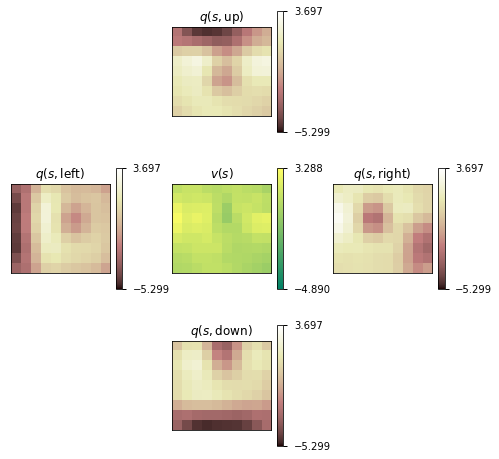

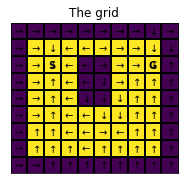

In [21]:
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

**Experience Replay with Linear Function Approximation**

/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


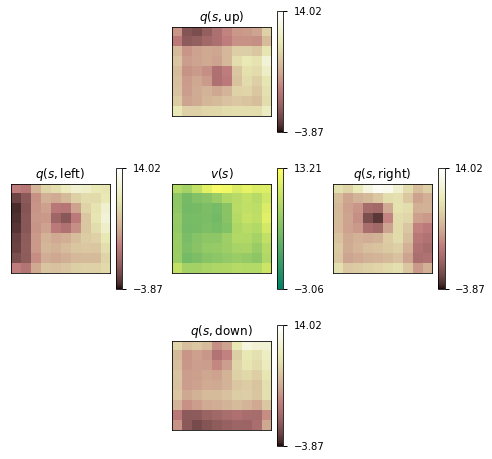

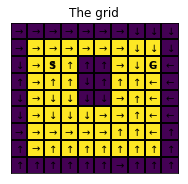

In [22]:
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

**DynaQ with Linear Function Approximation**

/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


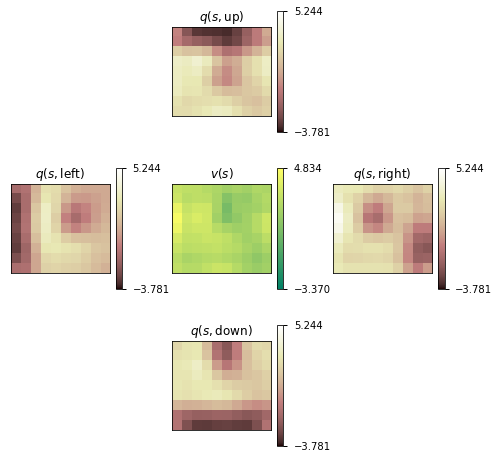

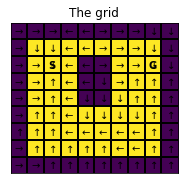

In [38]:
grid = FeatureGrid()

agent = FeatureDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in range(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

## 2.4 Non stationary Environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left).

The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

In [24]:
pretrain_steps = 2e4
new_env_steps = pretrain_steps / 30

**Online Q-learning**

/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


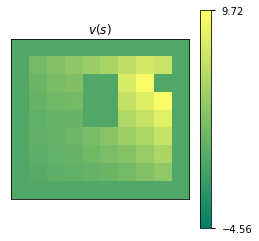

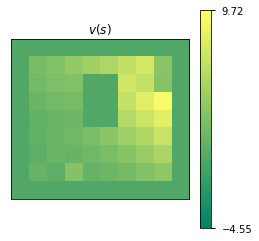

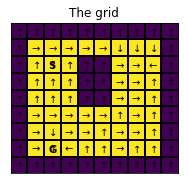

In [41]:
# Train on first environment
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)
plot_greedy_policy(alt_grid, q)

**Experience Replay**

/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


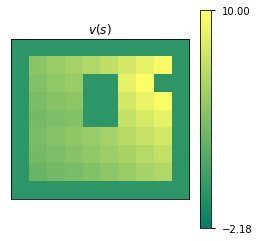

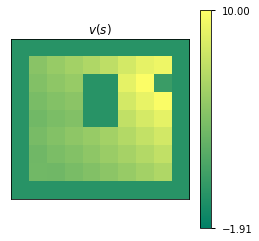

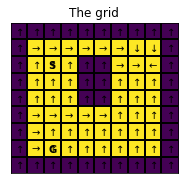

In [40]:
# Train on first environment
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)
plot_greedy_policy(alt_grid, q)

**Dyna**

/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/johngoodacre/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


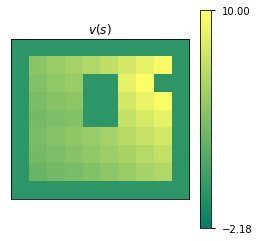

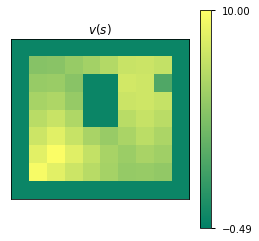

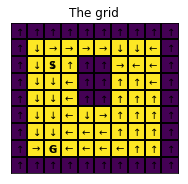

In [39]:
# Train on first environment
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)
plot_greedy_policy(alt_grid, q)

## Questions

### Basic Tabular Learning

**[5 pts]** Why is the ExperienceReplay agent so much more data efficient than online Q-learning?

**[5 pts]** If we run the experiments for the same number of updates, rather than the same number of steps in the environment, which among online Q-learning and Experience Replay performs better? Why?

**[5 pts]** Which among online Q-learning and Dyna-Q is more data efficient? why?

**[5 pts]** If we run the experiments for the same number of updates, rather than the same number of steps in the environment, which among online Q-learning and Dyna-Q performs better? Why?

### Linear function approximation

**[5 pts]** The value estimates with function approximation are considerably more blurry than in the tabular setting despite more training steps and interactions with the environment, why is this the case?

**[5 pts]** Inspect the policies derived by training agents with linear function approximation on `FeatureGrid` (as shown by `plot_greedy_policy`). How does this compare to the optimal policy? Are there any inconsistencies you can spot? What is the reason of these?

### Learning in a non stationary environment

Consider now the tabular but non-stationary setting of section 2.4.

After an initial pretraining phase, the goal location is moved to a new location, where the agent is allowed to train for some (shorter) time.

**[10 pts]** Compare the value estimates of online Q-learning and Experience Replay, after training also on the new goal location, explain what you see. 

**[10 pts]** Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location, explain what you see.

Back up your observations with visualizations of the value/policy.

